In [4]:
# Name :        Compare Algorithm's Confidence Level to its Performance
# Description : The script test whether conversation transcripts confidence is correlated with their accuracy
#               and visualize this correlation
# Arguments :   A json file of the transcript with confidence level
#               A txt file of the real transcript
# Returning :   None
# Author :      Yonathan Guttel <yesguttel@gmail.com
# Date :        13.02.2018
# Version :     1.0.0


In [5]:
# Import needed libraries
import os
import pandas as pd
import json
import requests
import difflib
import numpy as np
import seaborn as sns; sns.set(color_codes=True)
%matplotlib inline 
from scipy import stats

In [7]:
# The "element_json_extractor" recieves the transcript json file and can extract 
# the 'word', 'confidence', 'type', 'from' or 'to' elements as a list 

def element_json_extractor (json, element): #element can be 
    transcripts_list=[]
    # break json into parts
    terms = len(json)
    for term_n in range(terms):
        # extract the transcript part from each part of the json
        sub_json= json[term_n]['result'][0]['alternative'][0]['words']
        elements =len (sub_json)
        for element_n in range(elements):
            # build a list of all the desired elements
            transcripts_list.append(sub_json[element_n][element])
    # returning the list
    return  (transcripts_list)    

In [8]:
# The "text_levenshtein_distance" is computing the Levenshtein distance (the minimal edit distance) 
# between the two texts- in our case the predicted and true transcripts
def text_levenshtein_distance (words_list,true_data):
    d = difflib.Differ()
    compare_list=list(d.compare( words_list,true_data))
    return( compare_list)

In [9]:
# The "accuracy_confidence_correlation" function is the main function of this scripts
# it got two lists - a comparison list which is a product of the text_levenshtein_distance fun
# and a confidence_list which is a list of the confidence level of each word in the json transcript text 
# (produced by the element_json_extractor function ). its has also a optional parameter TH_min_num,
# which define what is the minimum number of occurances for a confidence level in the text in order to be 
# included in the analysis.
# The function return a data frame with two columns, the first column ids confidence levels and contain only 
# rows for which the occurance is greater than TH_min_num, and a second column with a ratio of the true 
# prediction out of all the prediction for the confidence level

def accuracy_confidence_correlation(compare_list,confidence_list, TH_min_num=0):
    # create vector with all possible confidence level
    confid_range=np.arange(0, 1.01, 0.01)
    confid_list=[str(round(a,2)) for a in  confid_range]
    #creates two list- one for true prediction and one for all prediction 
    correct_dic={el:0 for el in confid_list}
    total_dic={el:0 for el in confid_list}
    index=0
    # count cases in which the transcript list fits the true text ("-") and when it doesn't (" ")
    for i in range(len(compare_list)):
        if compare_list[i][0]==" " :
            conf_level=str(float(confidence_list[index]))
            total_dic[conf_level]=total_dic[conf_level]+1
            index+=1
        if compare_list[i][0]=="-" :
            conf_level=str(float(confidence_list[index]))
            correct_dic[conf_level]=correct_dic[conf_level]+1
            total_dic[conf_level]=total_dic[conf_level]+1
            index+=1
    # get the indices of all the confidence level that are greater than TH_min_num
    above_TH = np.where([(a>TH_min_num) for a in total_dic.values()])[0]
    # slice the dictionaries and create arrays of the only the levels which are greater thanTH_min_num 
    correct = [list(correct_dic.values())[i]for i in np.where([(a>TH_min_num) for a in total_dic.values()])[0]]
    total = [list(total_dic.values())[i]for i in np.where([(a>TH_min_num) for a in total_dic.values()])[0]]
    accuracy_per = np.divide(correct,total)
    confidence =confid_range [above_TH]
    #built a final df from arrays
    final_df = pd.DataFrame({'confidence':confidence, 'accuracy_per':accuracy_per})
    return (final_df)       
   

In [10]:
#run the script
#if __name__ == "__main__": # for other IDE

In [18]:
####################### Set parameters ######################
# minimum number of occurances for a confidence level in order to be included in the analysis
TH_min_num= 2 
#should extra visulation features be presnted
extra_vis =True
#set path
path= "path"

In [6]:
# Set WD (change it accordingly to where your files are located)
os.chdir(path)

In [19]:
# Upload data
predicted_json_data = json.load(open("9149298224668811_capio_transcript.json"))
true_data= open("9149298224668811_true_transcript.txt", "r").read().rstrip().split()

In [20]:
# Extract words and conf level
words_list = element_json_extractor (predicted_json_data, 'word')
confidence_list = element_json_extractor (predicted_json_data, 'confidence')

In [21]:
# Write transcript to file
with open('predicted_transcript.txt', mode="w") as outfile: 
    for word in words_list:
        outfile.write("%s\n" % word)

In [22]:
# Computing the Levenshtein distance (the minimal edit distance) between the predicted and true transcripts
compare_list=text_levenshtein_distance (words_list,true_data)

In [23]:
# Create a df for confidence and acuracy
results = accuracy_confidence_correlation(compare_list,confidence_list,TH_min_num=TH_min_num)
results = results[['confidence','accuracy_per']]

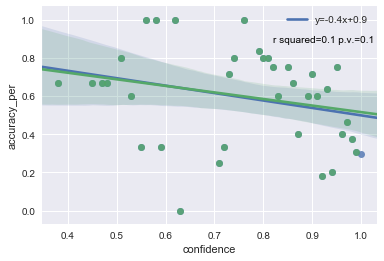

In [24]:
# Visualization

slope, intercept, r_value, p_value, std_err = stats.linregress((results[['confidence']].iloc[:,0]),(results[['accuracy_per']].iloc[:,0]))

ax = sns.regplot(x='confidence', y='accuracy_per', data=results,
                line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
ax.legend()


# if you wish to display the r squared and p.v.
if  extra_vis==True:
    ax.text(0.82,0.88, "r squared={0:.1f} p.v.={1:.1f}".format(r_value**2,p_value),
        size='medium', color='black')

    #if we remove confidence 1 (where there are many mistakes)
    ax2 = sns.regplot(x='confidence', y='accuracy_per', data=results.iloc[:-1,:])